In [1]:
import sys
sys.path.append("../../library/")
sys.path.append("../lib/")
import numpy as np
import matplotlib.pyplot as plt
import read_data as rd
from scipy.optimize import minimize_scalar
from sub_plot import *
from defaultPlot import *
from dataProcess import *
from stringFormat import *


In [2]:
time = {}
points = {}
#* ---------------------------------------------------------
orderParameter = {}
netOrderParameter = {}
singleOrderParameter = {}
meanClusterSize = {}
orderParameterVariance = {}
netOrderParameterVariance = {}
interEventTime = {}
#* ---------------------------------------------------------
orderParameterDist_t = {}
orderParameterDist = {}
clusterSizeDist_op = {}
clusterSizeDist = {}
#* ---------------------------------------------------------
interEventTime_orderParameter = {}

In [43]:
# for networkSize in networkSizeList:
for networkSize in [10000, 20000, 40000, 80000, 160000, 320000]:
# for networkSize in [10240000]:
    time[networkSize] = np.arange(0.0, 1.0, 1/networkSize)
    # for acceptanceThreshold in acceptanceThresholdList:
    for acceptanceThreshold in [0.5]:
        current = networkSize, acceptanceThreshold
        # points[current] = rd.readPoints(networkSize, acceptanceThreshold)
        #* -------------------------------------------------------
        orderParameter[current] = rd.read("orderParameter", networkSize, acceptanceThreshold)
        meanClusterSize[current] = rd.read("meanClusterSize", networkSize, acceptanceThreshold)
        orderParameterVariance[current] = rd.read("orderParameterVariance", networkSize, acceptanceThreshold)
        # interEventTime[current] = rd.read("interEventTime", networkSize, acceptanceThreshold)
        netOrderParameter[current] = {}
        netOrderParameterVariance[current] = {}
        for state in ["sub", "super"]:
            netOrderParameter[current][state] = rd.read("netOrderParameter", networkSize, acceptanceThreshold, state)
            netOrderParameterVariance[current][state] = rd.read("netOrderParameterVariance", networkSize, acceptanceThreshold, state)
        # singleOrderParameter[current] = rd.read("singleOrderParameter", networkSize, acceptanceThreshold)
        #* ---------------------------------------------------------
        # orderParameterDist_t[current] = rd.extractRepeater("orderParameterDist", networkSize, acceptanceThreshold)
        # for t in orderParameterDist_t[current]:
        #     orderParameterDist[current, t] = rd.read("orderParameterDist", networkSize, acceptanceThreshold, t)
        # clusterSizeDist_op[current] = rd.extractRepeater("clusterSizeDist", networkSize, acceptanceThreshold)
        # for op in clusterSizeDist_op[current]:
        #     clusterSizeDist[current, op] = rd.read("clusterSizeDist", networkSize, acceptanceThreshold, op)
        #* ---------------------------------------------------------

In [46]:
networkSize, acceptanceThreshold = 10240000, 0.5
current = networkSize, acceptanceThreshold

# Susceptibility

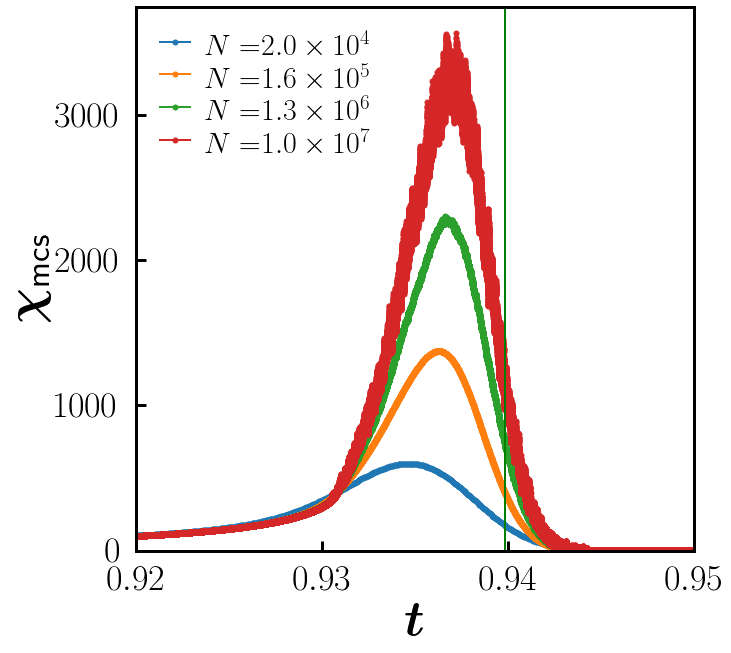

In [73]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

def plotMCS(acceptanceThreshold):
    for networkSize in [20000, 160000, 1280000, 10240000]:
        current = networkSize, acceptanceThreshold
        # t, chi = avgLinBin(time[networkSize], meanClusterSize[current], delta=3e-4)
        t, chi = time[networkSize], meanClusterSize[current]
        ax.plot(t, chi, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)
    ax.set_xlabel(latex_bold_string("t"))
    ax.set_ylabel(latex_bold_string("\chi_\\text{mcs}"))
    ax.set_xlim(chi_plotRange[acceptanceThreshold])
    ax.set_ylim(bottom = 0)
    ax.legend(loc="best", fontsize=30)

plotMCS(0.5)

t_c = points[current]["t_c"]
ax.plot([t_c,t_c], [0, 10000], 'g-', linewidth=2)

fig.show()


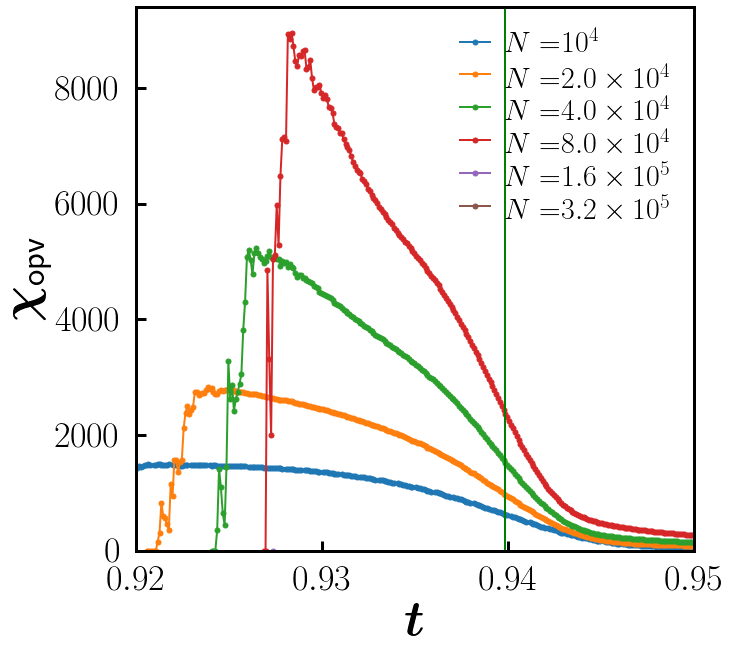

In [35]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

def plotMCS(acceptanceThreshold):
    for networkSize in [10000, 20000, 40000, 80000, 160000, 320000]:
        current = networkSize, acceptanceThreshold
        net_t, net_chi = netOrderParameterVariance[current]["super"]
        t, chi = avgLinBin(net_t/networkSize, net_chi, delta=1e-4)
        # t, chi = avgLinBin(time[networkSize], np.nan_to_num(orderParameterVariance[current], 0), delta=3e-4)
        ax.plot(t, chi, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)
    ax.set_xlabel(latex_bold_string("t"))
    ax.set_ylabel(latex_bold_string("\chi_\\text{opv}"))
    ax.set_xlim(chi_plotRange[acceptanceThreshold])
    ax.set_ylim(bottom = 0)
    ax.legend(loc="best", fontsize=30)

plotMCS(0.5)
t_c = points[current]["t_c"]
ax.plot([t_c,t_c], [0, 5e6], 'g-', linewidth=2)

fig.show()


# Finding gamma

Gamma: 6.2, nu_bar: 10


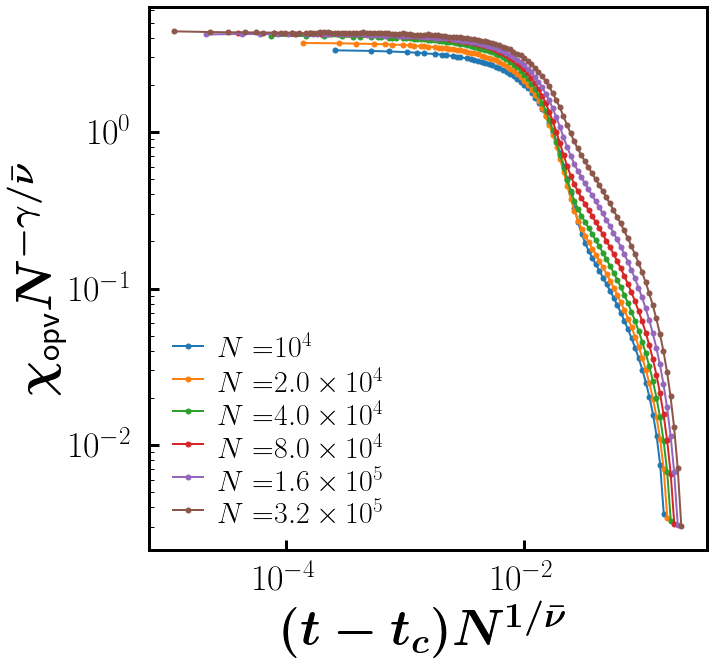

In [77]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

x = 0.62
nu_bar = 10
gamma = x * nu_bar
print("Gamma: " + str(gamma) + ", nu_bar: " + str(nu_bar))

t_c = points[current]["t_c"]
t_c = 0.936
def plotTX(region, scaled):
    for networkSize in [10000, 20000, 40000, 80000, 160000, 320000]:
        current = networkSize, acceptanceThreshold
        t, chi = netOrderParameterVariance[current]["super"]
        if region=="sub":
            reduced_t = t_c*networkSize - t
            reduced_t, chi = avgLogBin(reduced_t[reduced_t>0], chi[reduced_t > 0], delta_exponent=0.03)
        elif region == "super":
            reduced_t = t - t_c*networkSize
            reduced_t, chi = avgLogBin(reduced_t[reduced_t>0], chi[reduced_t > 0], delta_exponent=0.03)
        reduced_t /= networkSize
        if scaled:
            ax.plot(reduced_t * np.power(networkSize, 1/nu_bar), chi * np.power(networkSize, -x), 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)
        else:
            ax.plot(reduced_t, chi, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), markersize=5, linewidth=2)

    if scaled:
        ax.set_ylabel(latex_bold_string("\chi_\\text{opv} N^{-\gamma/\\bar{\\nu}}"))
        if region == "sub":
            ax.set_xlabel(latex_bold_string("(t_c-t)N^{1/\\bar{\\nu}}"))
        elif region == "super":
            ax.set_xlabel(latex_bold_string("(t-t_c)N^{1/\\bar{\\nu}}"))
    else:
        ax.set_ylabel(latex_bold_string("\chi_\\text{opv}"))
        if region == "sub":
            ax.set_xlabel(latex_bold_string("t_c-t"))
        elif region == "super":
            ax.set_xlabel(latex_bold_string("t_c-t"))

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc="best", fontsize=30)

# plotTX("sub", False)
# plotTX("sub", True)
# plotTX("super", False)
plotTX("super", True)

fig.show()


# Finding beta

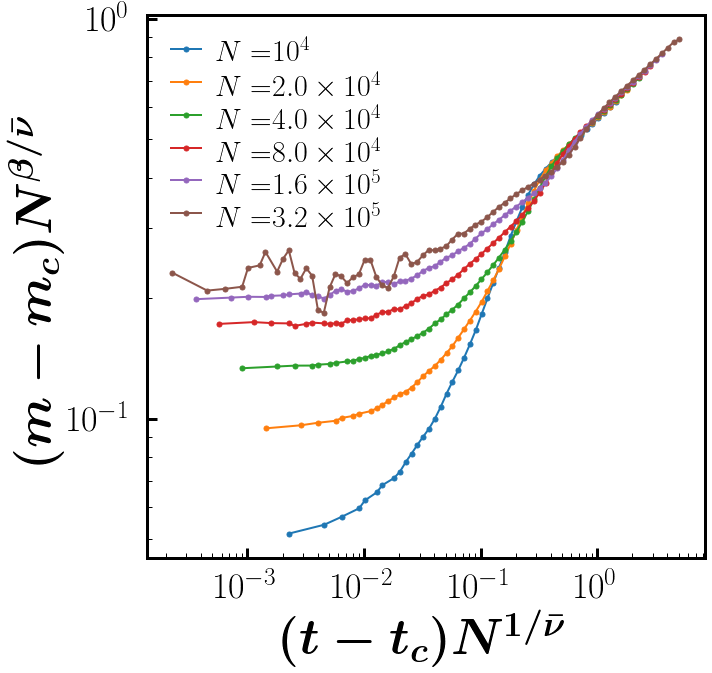

In [83]:
fig, ax = plt.subplots()
ax.set_rasterized(True)

acceptanceThreshold = 0.5
t_c = 0.93
m_c = 0.75

x = 0.1
nu_bar = 3.0
beta = x * nu_bar

def plotTOP(scaled):
    for networkSize in [10000, 20000, 40000, 80000, 160000, 320000]:
        current = networkSize, acceptanceThreshold
        net_t, net_op = netOrderParameter[current]["super"]
        reduced_t, reduced_op = net_t - t_c * networkSize, net_op - m_c
        reduced_t, reduced_op = reduced_t[reduced_t > 0], reduced_op[reduced_t > 0]
        reduced_t, reduced_op = avgLogBin(reduced_t[reduced_op > 0], reduced_op[reduced_op > 0], delta_exponent=0.05)
        # print(reduced_t[0] + t_c * networkSize)
        reduced_t /= networkSize

        if scaled:
            ax.plot(reduced_t * np.power(networkSize, 1.0 / nu_bar), reduced_op * np.power(networkSize, x), 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), linewidth=2, markersize=5)
        else:
            ax.plot(reduced_t, reduced_op, 'o-', label=latex_string("N=") + latex_sci(networkSize, 1), linewidth=2, markersize=5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc="best", fontsize=30)
    if scaled:
        ax.set_xlabel(latex_bold_string("(t-t_c)N^{1/\\bar{\\nu}}"))
        ax.set_ylabel(latex_bold_string("(m-m_c)N^{\\beta/\\bar{\\nu}}"))
    else:
        ax.set_xlabel(latex_bold_string("t-t_c"))
        ax.set_ylabel(latex_bold_string("m-m_c"))


plotTOP(scaled=True)
# plotTOP(scaled=False)

fig.show()
